You can read an overview of this Numerical Linear Algebra course in [this blog post](http://www.fast.ai/2017/07/17/num-lin-alg/).  The course was originally taught in the [University of San Francisco MS in Analytics](https://www.usfca.edu/arts-sciences/graduate-programs/analytics) graduate program.  Course lecture videos are [available on YouTube](https://www.youtube.com/playlist?list=PLtmWHNX-gukIc92m1K0P6bIOnZb-mg0hY) (note that the notebook numbers and video numbers do not line up, since some notebooks took longer than 1 video to cover).

You can ask questions about the course on [our fast.ai forums](http://forums.fast.ai/c/lin-alg).

# 8. Implementing QR Factorization

We used QR factorization in computing eigenvalues and to compute least squares regression. It is an important building block in numerical linear algebra.

"One algorithm in numerical linear algebra is more important than all the others: QR factorization." --Trefethen, page 48

Recall that for any matrix $A$, $A = QR$ where $Q$ is orthogonal and $R$ is upper-triangular.

**Reminder**: The *QR algorithm*, which we looked at in the last lesson, uses the *QR decomposition*, but don't confuse the two.

### In Numpy ###

In [5]:
import numpy as np

np.set_printoptions(suppress=True, precision=4)

In [6]:
n = 5
A = np.random.rand(n,n)
npQ, npR = np.linalg.qr(A)

Check that Q is orthogonal:

In [7]:
np.allclose(np.eye(n), npQ @ npQ.T), np.allclose(np.eye(n), npQ.T @ npQ)

(True, True)

Check that R is triangular

In [8]:
npR

array([[-0.8524, -0.7872, -1.1163, -1.2248, -0.7587],
       [ 0.    , -0.9363, -0.2958, -0.7666, -0.632 ],
       [ 0.    ,  0.    ,  0.4645, -0.1744, -0.3542],
       [ 0.    ,  0.    ,  0.    ,  0.4328, -0.2567],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.1111]])

## Gram-Schmidt ##

### Classical Gram-Schmidt (unstable) ###

For each $j$, calculate a single projection $$v_j = P_ja_j$$ where $P_j$ projects onto the space orthogonal to the span of $q_1,\ldots,q_{j-1}$.

In [10]:
def cgs(A):
    m, n = A.shape
    Q = np.zeros([m,n], dtype=np.float64)
    R = np.zeros([n,n], dtype=np.float64)
    for j in range(n):
        v = A[:,j]
        for i in range(j):
            R[i,j] = np.dot(Q[:,i], A[:,j])
            v = v - (R[i,j] * Q[:,i])
        R[j,j] = np.linalg.norm(v)
        Q[:, j] = v / R[j,j]
    return Q, R

In [11]:
Q, R = cgs(A)

In [12]:
np.allclose(A, Q @ R)

True

Check if Q is unitary:

In [109]:
np.allclose(np.eye(len(Q)), Q.dot(Q.T))

True

In [115]:
np.allclose(npQ, -Q)

True

Gram-Schmidt should remind you a bit of the Arnoldi Iteration (used to transform a matrix to Hessenberg form) since it is also a structured orthogonalization.

### Modified Gram-Schmidt ###

Classical (unstable) Gram-Schmidt: for each $j$, calculate a single projection $$v_j = P_ja_j$$ where $P_j$ projects onto the space orthogonal to the span of $q_1,\ldots,q_{j-1}$.

Modified Gram-Schmidt: for each $j$, calculate $j-1$ projections $$P_j = P_{\perp q_{j-1}\cdots\perp q_{2}\perp q_{1}}$$

In [30]:
import numpy as np
n = 3
A = np.random.rand(n,n).astype(np.float64)

In [33]:
def mgs(A):
    V = A.copy()
    m, n = A.shape
    Q = np.zeros([m,n], dtype=np.float64)
    R = np.zeros([n,n], dtype=np.float64)
    for i in range(n):
        R[i,i] = np.linalg.norm(V[:,i])
        Q[:,i] = V[:,i] / R[i,i]
        for j in range(i, n):
            R[i,j] = np.dot(Q[:,i],V[:,j])
            V[:,j] = V[:,j] - R[i,j]*Q[:,i]
    return Q, R

In [34]:
Q, R = mgs(A)

In [35]:
np.allclose(np.eye(len(Q)), Q.dot(Q.T.conj()))

True

In [36]:
np.allclose(A, np.matmul(Q,R))

True

## Householder

### Intro

\begin{array}{ l | l | c }
\hline
Gram-Schmidt & Triangular\, Orthogonalization & A R_1 R_2 \cdots R_n = Q  \\
Householder  & Orthogonal\, Triangularization & Q_n \cdots Q_2 Q_1 A = R  \\
\hline
\end{array}

Householder reflections lead to a more nearly orthogonal matrix Q with rounding errors

Gram-Schmidt can be stopped part-way, leaving a reduced QR of 1st n columns of A

### Initialization

In [113]:
import numpy as np
n = 4
A = np.random.rand(n,n).astype(np.float64)

Q = np.zeros([n,n], dtype=np.float64)
R = np.zeros([n,n], dtype=np.float64)

In [114]:
A

array([[ 0.5435,  0.6379,  0.4011,  0.5773],
       [ 0.0054,  0.8049,  0.6804,  0.0821],
       [ 0.2832,  0.2416,  0.8656,  0.8099],
       [ 0.1139,  0.9621,  0.7623,  0.5648]])

In [115]:
from scipy.linalg import block_diag

In [116]:
np.set_printoptions(5)

### Algorithm

I added more computations and more info than needed, since it's illustrative of how the algorithm works.  This version returns the *Householder Reflectors* as well.

In [117]:
def householder_lots(A):
    m, n = A.shape
    R = np.copy(A)
    V = []
    Fs = []
    for k in range(n):
        v = np.copy(R[k:,k])
        v = np.reshape(v, (n-k, 1))
        v[0] += np.sign(v[0]) * np.linalg.norm(v)
        v /= np.linalg.norm(v)
        R[k:,k:] = R[k:,k:] - 2*np.matmul(v, np.matmul(v.T, R[k:,k:]))
        V.append(v)
        F = np.eye(n-k) - 2 * np.matmul(v, v.T)/np.matmul(v.T, v)
        Fs.append(F)
    return R, V, Fs

Check that R is upper triangular:

In [121]:
R

array([[-0.62337, -0.84873, -0.88817, -0.97516],
       [ 0.     , -1.14818, -0.86417, -0.30109],
       [ 0.     ,  0.     , -0.64691, -0.45234],
       [-0.     ,  0.     ,  0.     , -0.26191]])

As a check, we will calculate $Q^T$ and $R$ using the block matrices $F$.  The matrices $F$ are *the householder reflectors*.

Note that this is not a computationally efficient way of working with $Q$.  In most cases, you do not actually need $Q$.  For instance, if you are using QR to solve least squares, you just need $Q^*b$.

- See page 74 of Trefethen for techniques to implicitly calculate the product $Q^*b$ or $Qx$.
- See [these lecture notes](http://www.cs.cornell.edu/~bindel/class/cs6210-f09/lec18.pdf) for a different implementation of Householder that calculates Q simultaneously as part of R. 

In [175]:
QT = np.matmul(block_diag(np.eye(3), F[3]), 
               np.matmul(block_diag(np.eye(2), F[2]), 
                         np.matmul(block_diag(np.eye(1), F[1]), F[0])))

In [178]:
F[1]

array([[-0.69502,  0.10379, -0.71146],
       [ 0.10379,  0.99364,  0.04356],
       [-0.71146,  0.04356,  0.70138]])

In [177]:
block_diag(np.eye(1), F[1])

array([[ 1.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     , -0.69502,  0.10379, -0.71146],
       [ 0.     ,  0.10379,  0.99364,  0.04356],
       [ 0.     , -0.71146,  0.04356,  0.70138]])

In [176]:
np.matmul(block_diag(np.eye(1), F[1]), F[0])

array([[-0.87185, -0.00861, -0.45431, -0.18279],
       [ 0.08888, -0.69462,  0.12536, -0.70278],
       [-0.46028,  0.10167,  0.88193, -0.00138],
       [-0.14187, -0.71211,  0.00913,  0.68753]])

In [123]:
QT

array([[-0.87185, -0.00861, -0.45431, -0.18279],
       [ 0.08888, -0.69462,  0.12536, -0.70278],
       [ 0.45817, -0.112  , -0.88171,  0.01136],
       [ 0.14854,  0.71056, -0.02193, -0.68743]])

In [124]:
R2 = np.matmul(block_diag(np.eye(3), F[3]), 
               np.matmul(block_diag(np.eye(2), F[2]),
                         np.matmul(block_diag(np.eye(1), F[1]), 
                                   np.matmul(F[0], A))))

In [125]:
np.allclose(A, np.matmul(np.transpose(QT), R2))

True

In [126]:
np.allclose(R, R2)

True

Here's a concise version of Householder (although I do create a new R, instead of overwriting A and computing it in place).

In [179]:
def householder(A):
    m, n = A.shape
    R = np.copy(A)
    Q = np.eye(m)
    V = []
    for k in range(n):
        v = np.copy(R[k:,k])
        v = np.reshape(v, (n-k, 1))
        v[0] += np.sign(v[0]) * np.linalg.norm(v)
        v /= np.linalg.norm(v)
        R[k:,k:] = R[k:,k:] - 2 * v @ v.T @ R[k:,k:]
        V.append(v)
    return R, V

In [157]:
RH, VH = householder(A)

Check that R is diagonal:

In [129]:
RH

array([[-0.62337, -0.84873, -0.88817, -0.97516],
       [-0.     , -1.14818, -0.86417, -0.30109],
       [-0.     , -0.     , -0.64691, -0.45234],
       [-0.     ,  0.     ,  0.     , -0.26191]])

In [130]:
VH

[array([[ 0.96743],
        [ 0.00445],
        [ 0.2348 ],
        [ 0.09447]]), array([[ 0.9206 ],
        [-0.05637],
        [ 0.38641]]), array([[ 0.99997],
        [-0.00726]]), array([[ 1.]])]

In [131]:
np.allclose(R, RH)

True

In [132]:
def implicit_Qx(V,x):
    n = len(x)
    for k in range(n-1,-1,-1):
        x[k:n] -= 2*np.matmul(v[-k], np.matmul(v[-k], x[k:n]))

In [133]:
A

array([[ 0.54348,  0.63791,  0.40114,  0.57728],
       [ 0.00537,  0.80485,  0.68037,  0.0821 ],
       [ 0.2832 ,  0.24164,  0.86556,  0.80986],
       [ 0.11395,  0.96205,  0.76232,  0.56475]])

Both classical and modified Gram-Schmidt require $2mn^2$ flops.

### Gotchas

Some things to be careful about:
- when you've copied values vs. when you have two variables pointing to the same memory location
- the difference between a vector of length n and a 1 x n matrix (np.matmul deals with them differently)

## Analogy

|                              | $A = QR$     | $A = QHQ^*$ |
|------------------------------|--------------|-------------|
| orthogonal structuring       | Householder  | Householder |
| structured orthogonalization | Gram-Schmidt | Arnoldi     |

**Gram-Schmidt and Arnoldi**: succession of triangular operations, can be stopped part way and first $n$ columns are correct

**Householder**: succession of orthogoal operations.  Leads to more nearly orthogonal A in presence of rounding errors.

Note that to compute a Hessenberg reduction $A = QHQ^*$, Householder reflectors are applied to two sides of A, rather than just one.

# Examples

The following examples are taken from Lecture 9 of Trefethen and Bau, although translated from MATLAB into Python

### Ex: Classical vs Modified Gram-Schmidt ###

This example is experiment 2 from section 9 of Trefethen. We want to construct a square matrix A with random singular vectors and widely varying singular values spaced by factors of 2 between $2^{-1}$ and $2^{-(n+1)}$

In [68]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

In [183]:
n = 100
U, X = np.linalg.qr(np.random.randn(n,n))   # set U to a random orthogonal matrix
V, X = np.linalg.qr(np.random.randn(n,n))   # set V to a random orthogonal matrix
S = np.diag(np.power(2,np.arange(-1,-(n+1),-1), dtype=float))  # Set S to a diagonal matrix w/ exp 
                                                              # values between 2^-1 and 2^-(n+1)

In [184]:
A = np.matmul(U,np.matmul(S,V))

In [188]:
QC, RC = cgs(A)
QM, RM = mgs(A)

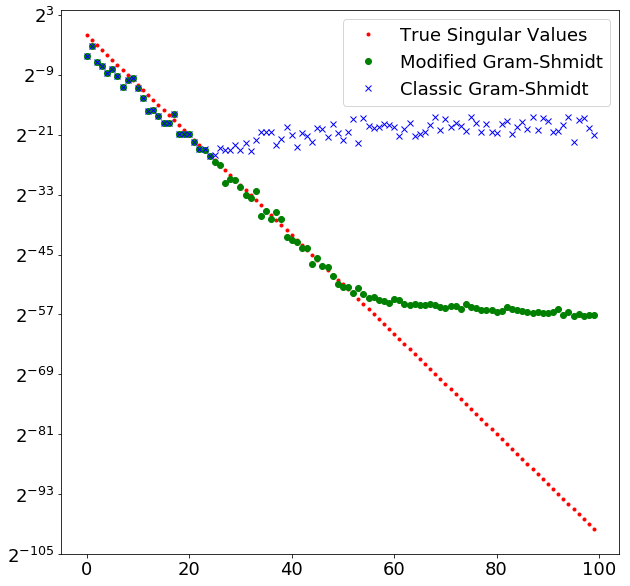

In [189]:
plt.figure(figsize=(10,10))
plt.semilogy(np.diag(S), 'r.', basey=2, label="True Singular Values")
plt.semilogy(np.diag(RM), 'go', basey=2, label="Modified Gram-Shmidt")
plt.semilogy(np.diag(RC), 'bx', basey=2, label="Classic Gram-Shmidt")
plt.legend()
rcParams.update({'font.size': 18})

In [94]:
type(A[0,0]), type(RC[0,0]), type(S[0,0])

(numpy.float64, numpy.float64, numpy.float64)

In [92]:
eps = np.finfo(np.float64).eps; eps

2.2204460492503131e-16

In [93]:
np.log2(eps), np.log2(np.sqrt(eps))

(-52.0, -26.0)

### Ex 9.3: Numerical loss of orthogonality

This example is experiment 3 from section 9 of Trefethen.

In [95]:
A = np.array([[0.70000, 0.70711], [0.70001, 0.70711]])

Gram-Schmidt:

In [96]:
Q1, R1 = mgs(A)

Householder:

In [105]:
R2, V, F = householder_lots(A)
Q2T = np.matmul(block_diag(np.eye(1), F[1]), F[0])

Numpy's Householder:

In [106]:
Q3, R3 = np.linalg.qr(A)

Check that all the QR factorizations work:

In [107]:
np.matmul(Q1, R1)

array([[ 0.7   ,  0.7071],
       [ 0.7   ,  0.7071]])

In [108]:
np.matmul(Q2T.T, R2)

array([[ 0.7   ,  0.7071],
       [ 0.7   ,  0.7071]])

In [109]:
np.matmul(Q3, R3)

array([[ 0.7   ,  0.7071],
       [ 0.7   ,  0.7071]])

Check how close Q is to being perfectly orthonormal:

In [110]:
np.linalg.norm(np.matmul(Q1.T, Q1) - np.eye(2))  # Modified Gram-Schmidt

3.2547268868202263e-11

In [111]:
np.linalg.norm(np.matmul(Q2T.T, Q2T) - np.eye(2))  # Our implementation of Householder

1.1110522984689321e-16

In [112]:
np.linalg.norm(np.matmul(Q3.T, Q3) - np.eye(2))  # Numpy (which uses Householder)

2.5020189909116529e-16

GS (Q1) is less stable than Householder (Q2T, Q3)

# End